In [1]:
import os
import json
import time
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.feature as cf
import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound

import psutil
from joblib import Parallel, delayed

from scipy.optimize import differential_evolution

from pathos.multiprocessing import ProcessingPool as Pool

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_downscale import myfun_sse, fit_yearly_weibull_update, gamma_manual
from ART_preprocessing import create_box, autocorrelation_neighborhood

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
# product, time_reso = 'IMERG', '1dy'

# product, time_reso = 'IMERG', '3h'
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'CMORPH', '3h'
product, time_reso = 'PERSIANN', '1dy'
# product, time_reso = 'SM2RAIN', '1dy'

yy_s, yy_e = 2002, 2012
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['GAMMA_cores']}')

Read json file   : IMERG_1dy.json
Number of threads: 27


In [4]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [5]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [6]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1.5, lat_min-1.5), lon=slice(lon_min-1.5, lon_max+1.5))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1.5, lat_max+1.5), lon=slice(lon_min-1.5, lon_max+1.5))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data

Reading data: IMERG_Italy_1dy_2000_06_01_2024_02_29.nc


<xarray.Dataset> Size: 96MB
Dimensions:  (time: 4018, lat: 50, lon: 60)
Coordinates:
  * time     (time) datetime64[ns] 32kB 2002-01-01 2002-01-02 ... 2012-12-31
  * lat      (lat) float64 400B 43.05 43.15 43.25 43.35 ... 47.75 47.85 47.95
  * lon      (lon) float32 240B 9.05 9.15 9.25 9.35 ... 14.65 14.75 14.85 14.95
Data variables:
    PRE      (time, lat, lon) float64 96MB ...
Attributes:
    description:  IMERG daily data for Italy region

In [7]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN':
    ds_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    ds_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

lat_ref = ds_veneto.lat.values
lon_ref = ds_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

ds_veneto

<xarray.Dataset> Size: 24MB
Dimensions:  (time: 4018, lat: 25, lon: 30)
Coordinates:
  * time     (time) datetime64[ns] 32kB 2002-01-01 2002-01-02 ... 2012-12-31
  * lat      (lat) float64 200B 44.55 44.65 44.75 44.85 ... 46.75 46.85 46.95
  * lon      (lon) float32 120B 10.55 10.65 10.75 10.85 ... 13.25 13.35 13.45
Data variables:
    PRE      (time, lat, lon) float64 24MB ...
Attributes:
    description:  IMERG daily data for Italy region

In [8]:
del ds_veneto

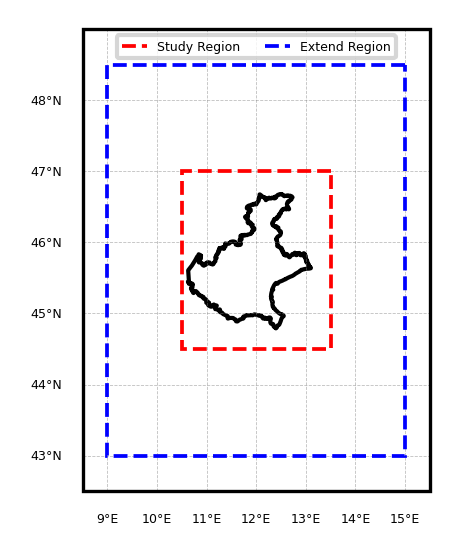

In [9]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(2,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min-2, lon_max+2, lat_min-2, lat_max+2],crs=proj)
VENETO.plot(facecolor='None', ax=ax1)

ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.9,edgecolor='r',facecolor='None',zorder=5))
ax1.add_patch(patches.Rectangle((lon_max+1.5,lat_max+1.5),(lon_min-1.5)-(lon_max+1.5),(lat_min-1.5)-(lat_max+1.5),linestyle='--',linewidth=0.9,edgecolor='b',facecolor='None',zorder=5))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.plot([],[],linestyle='--',linewidth=0.9,color='r', label='Study Region')
ax1.plot([],[],linestyle='--',linewidth=0.9,color='b', label='Extend Region')

ax1.legend(fontsize=3,ncols=2,loc='upper center')

In [10]:
def gamma_3h_1dy(DATA_in, time_reso, lat_c, lon_c, PARAM):
    if time_reso == '3h':
        PRE_daily = DATA_in.resample(time ='D').sum(dim='time', skipna=False)
        box_3h, _ = create_box(PRE_daily, lat_c, lon_c, PARAM['npix'], PARAM['radio'])
        tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*PARAM['dt']
    elif time_reso == '1dy':
        tscales = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])*PARAM['dt']
        box_3h, _ = create_box(DATA_in, lat_c, lon_c, PARAM['npix'], PARAM['radio'])
        PRE_daily = DATA_in
    else:
        print(f'Erorr: {time_reso} not valid')
        return None

    i_ = np.where(lats==lat_c)[0][0]
    j_ = np.where(lons==lon_c)[0][0]

    IMERG_pixel_1dy = PRE_daily['PRE'][:,i_,j_].data
    IMERG_pixel_1dy_xr = xr.DataArray(
                IMERG_pixel_1dy, 
                coords={'time':PRE_daily['time'].values}, 
                dims=('time'))

    IMERG_WEIBULL_YEAR = fit_yearly_weibull_update(
                    IMERG_pixel_1dy_xr, 
                    thresh=PARAM['thresh'], 
                    maxmiss=PARAM['maxmiss'])

    vdist, vcorr, _ = autocorrelation_neighborhood(
                    box_3h, 
                    t_target = PARAM['target_t'], 
                    thresh = PARAM['thresh'], 
                    cor_method = PARAM['corr_method'])

    vdist_sorted = np.sort(vdist) # order distance
    vcorr_sorted = vcorr[np.argsort(vdist)] # order correlation in relation to distance
    toll_cluster = 0.5

    cluster = np.zeros(len(vdist_sorted))
    count = 0
    for i in range(1, len(vdist_sorted)):
        if np.abs(vdist_sorted[i]-vdist_sorted[i-1]) < toll_cluster:
            cluster[i] = count
        else:
            count = count + 1
            cluster[i] = count

    clust = set(cluster) # Extract only the uniques values
    nclust = len(clust) # Numero de grupos

    vdist_ave = np.zeros(nclust)
    vcorr_ave = np.zeros(nclust)
    for ei, elem in enumerate(clust):
        di = vdist_sorted[cluster==elem] # Distance
        ci = vcorr_sorted[cluster==elem] # Correlation
        vdist_ave[ei] = np.mean(di) # Mean Distance
        vcorr_ave[ei] = np.mean(ci) # Mean Correlation

    bounds = [(0.0, 25.0),(0, 0.3)] # NEW LIMITS USING ALL CORRELATIONS FUNCTION IN VENETO

    def myfun(pardown):
        return myfun_sse(vdist_ave, vcorr_ave, pardown, PARAM['L1'], acf=PARAM['acf'])

    resmin = differential_evolution(
                myfun,
                bounds,
                disp=True,
                tol=0.03,
                atol=0.03,
                workers=1,
                updating='deferred'
            )

    param1 = resmin.x[0]
    param2 = resmin.x[1]

    gamma = gamma_manual(IMERG_WEIBULL_YEAR[:,0], 
                        IMERG_WEIBULL_YEAR[:,1], 
                        IMERG_WEIBULL_YEAR[:,2], 
                        PARAM['L1'], 
                        PARAM['L0'], 
                        (param1, param2), 
                        acf=PARAM['acf'])

    return gamma

In [12]:
def compute_for_point(lat_idx, lon_idx):
    return gamma_3h_1dy(PRE_data, time_reso, lats[lat_idx], lons[lon_idx], param)

Resource = []

start_time = time.time()

results = Parallel(n_jobs=param['GAMMA_cores'])(
    delayed(compute_for_point)(la, lo) for la in ndices_lat for lo in ndices_lon
    )

end_time = time.time()

elapsed_time = end_time - start_time
elapsed_minutes = elapsed_time / 60
# memory_consumed = psutil.virtual_memory().used / 1024 ** 3

print(f"Elapsed time: {elapsed_minutes:.2f} minutes")
# print(f"Memory consumed: {memory_consumed:.3f} GB")

differential_evolution step 1: f(x)= 0.0004944136398356517
differential_evolution step 1: f(x)= 0.000388062745712353
Polishing solution with 'L-BFGS-B'
differential_evolution step 1: f(x)= 0.00026814107596319993
differential_evolution step 1: f(x)= 0.0002887410249310281
Polishing solution with 'L-BFGS-B'
differential_evolution step 1: f(x)= 0.0005020414724583856
Polishing solution with 'L-BFGS-B'
differential_evolution step 1: f(x)= 0.0002521954282055901
differential_evolution step 1: f(x)= 0.0005866905941382472
differential_evolution step 1: f(x)= 0.0004401516668163275
Polishing solution with 'L-BFGS-B'
differential_evolution step 1: f(x)= 0.00040163290466305017
Polishing solution with 'L-BFGS-B'
differential_evolution step 1: f(x)= 0.000125045448278274
differential_evolution step 1: f(x)= 0.0006251952043888752
differential_evolution step 1: f(x)= 0.00023747183740553405
differential_evolution step 1: f(x)= 0.0003026426271052805
Polishing solution with 'L-BFGS-B'
differential_evolution

In [13]:
GAMMA_VENETO = np.array(results).reshape(len(ndices_lat), len(ndices_lon))

In [14]:
#Export beta as netcdf
GAMMA_xr = xr.Dataset(data_vars={"GAMMA": (("lat","lon"), GAMMA_VENETO.data)},
                    coords={'lat': lats[ndices_lat], 'lon': lons[ndices_lon]},
                    attrs=dict(description=f"GAMMA of {product} for Veneto region limited as 10.5E to 13.5E and 44.5N to 47N"))

GAMMA_xr.GAMMA.attrs["units"] = "dimensionless"
GAMMA_xr.GAMMA.attrs["long_name"] = "Relation between Origin and Tarjet wet fraction"
GAMMA_xr.GAMMA.attrs["origname"] = "GAMMA"

GAMMA_xr.lat.attrs["units"] = "degrees_north"
GAMMA_xr.lat.attrs["long_name"] = "Latitude"

GAMMA_xr.lon.attrs["units"] = "degrees_east"
GAMMA_xr.lon.attrs["long_name"] = "Longitude"

In [15]:
GAMMA_xr

<xarray.Dataset> Size: 6kB
Dimensions:  (lat: 25, lon: 30)
Coordinates:
  * lat      (lat) float64 200B 44.55 44.65 44.75 44.85 ... 46.75 46.85 46.95
  * lon      (lon) float32 120B 10.55 10.65 10.75 10.85 ... 13.25 13.35 13.45
Data variables:
    BETA     (lat, lon) float64 6kB 0.953 0.9472 0.9568 ... 0.9496 0.9515 0.9537
Attributes:
    description:  Gamma of IMERG for Veneto region limited as 10.5E to 13.5E ...

In [16]:
GAMMA_out = os.path.join(dir_base,'2_GAMMA',f'VENETO_GAMMA_{product}_{time_reso}_{yy_s}_{yy_e}.nc')
print(f'Export PRE data to {GAMMA_out}')
GAMMA_xr.to_netcdf(GAMMA_out)

Export PRE data to /media/arturo/Arturo/Data/Italy/Satellite/2_GAMMA/VENETO_GAMMA_IMERG_1dy_2002_2012.nc


In [17]:
playsound("../sound/HOMER_DOH.mp3")